In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import quimb as qu
import quimb.tensor as qtn
from merabuilder import *

# generate an OBC ternary MERA

In [2]:
rng = np.random.default_rng(666)

mera = MERA.from_fill_fn(
    fill_fn=lambda shape: rng.normal(size=shape),
    L=100,         # number of sites, (doesn't have to be a power of block_size)
    D=4,           # max bond dimension
    block_size=3,  # make a ternary MERA
    cyclic=False,  # OBC
)

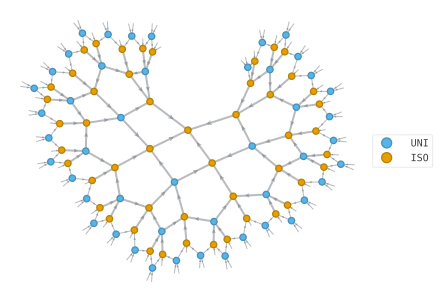

In [3]:
mera.draw(['UNI', 'ISO'])

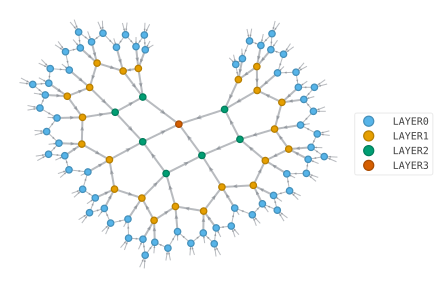

In [4]:
mera.draw([f"LAYER{i}" for i in range(mera.num_layers)])

# rehearse the necessary contractions for Hamiltonian evaluation

In [5]:
ham = qtn.ham_1d_heis(L=mera.L, cyclic=False)

In [6]:
trees = mera.compute_local_expectation(
    ham,
    rehearse='tree',
    optimize='auto-hq',
    progbar=True
)

 99%|#########8| 98/99 [00:09<00:00, 10.20it/s]


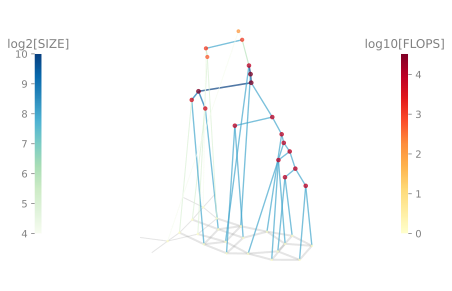

In [7]:
# check a random tree
tuple(trees.values())[50].plot_tent(order=True)

In [8]:
# check the total approx flops
total_cost = sum(tree.total_cost() for tree in trees.values())
qu.log10(total_cost)

7.966590575299636

# perform an optimization

In [9]:
def norm_fn(mera):
    return mera.unitize()

def loss_fn(mera, terms):
    return mera.compute_local_expectation(
        terms, optimize='auto-hq',
    ) / mera.L

In [10]:
tnopt = qtn.TNOptimizer(
    mera,
    loss_fn,
    norm_fn=norm_fn,
    loss_constants=dict(terms=ham.terms),
    optimizer='adam',
    autodiff_backend='torch',
    device='cuda',
    jit_fn=True,
)

In [11]:
tnopt.optimize(1000)

-0.403195089787 [best: -0.403195089787] : : 1001it [03:05,  5.40it/s]                        


<MERA(tensors=96, indices=242, L=100, max_bond=4)>

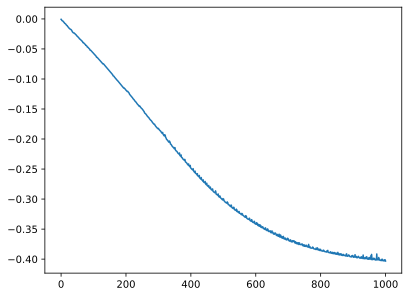

In [12]:
import matplotlib.pyplot as plt
plt.plot(tnopt.losses)

# custom build a 2D MERA

In [13]:
sites = [(i, j) for j in range(4) for i in range(4)]
mera2d = TensorNetworkGenIso.empty(sites)

In [14]:
fill_fn = lambda shape: rng.normal(size=shape)
max_bond = 4

In [15]:
# layer of disentanglers
for where in [
    # horizonatal disentangle
    ((0, 1), (0, 2)),
    ((1, 1), (1, 2)),
    ((2, 1), (2, 2)),
    ((3, 1), (3, 2)),
    # vertical disentangle
    ((1, 0), (2, 0)),
    ((1, 1), (2, 1)),
    ((1, 2), (2, 2)),
    ((1, 3), (2, 3)),
]:
    mera2d.layer_gate_fill_fn(
        fill_fn=fill_fn, 
        operation='uni', 
        where=where, 
        max_bond=max_bond
    )

# group the corners with isometries
for where in [
    ((0, 0), (0, 1), (1, 0), (1, 1)),
    ((0, 2), (0, 3), (1, 2), (1, 3)),
    ((2, 0), (2, 1), (3, 0), (3, 1)),
    ((2, 2), (2, 3), (3, 2), (3, 3)),
]:
    # by default the sites that are 'kept' are the first: (0, 0), (0, 2), ...
    mera2d.layer_gate_fill_fn(
        fill_fn=fill_fn, 
        operation='iso', 
        where=where, 
        max_bond=max_bond
    )

# cap the 4 remaining open indices with tree
mera2d.layer_gate_fill_fn(
    fill_fn=fill_fn, 
    operation='cap', 
    where=tuple(mera2d._open_upper_sites), 
    max_bond=max_bond
)

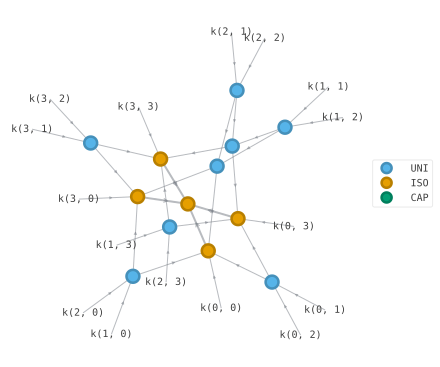

In [16]:
mera2d.draw(['UNI', 'ISO', 'CAP'], show_tags=False)

In [17]:
mera2d.unitize_()

<TensorNetworkGenIso(tensors=13, indices=36)>

In [18]:
mera2d.partial_trace([(1, 1), (2, 2)])

[[ 0.233209  0.004699 -0.039604 -0.003342]
 [ 0.004699  0.255603 -0.002426 -0.045234]
 [-0.039604 -0.002426  0.260896  0.02068 ]
 [-0.003342 -0.045234  0.02068   0.250292]]